In [2]:
import os
import requests
import tarfile
import zipfile
from tqdm import tqdm

def download_and_extract(url, target_path, is_zip=False, is_tar=False):
    """Prenese in razširi datoteko iz URL-ja."""
    if not os.path.exists(target_path):
        os.makedirs(target_path)

    filename = url.split('/')[-1]
    filepath = os.path.join(target_path, filename)

    # Prenos datoteke s prikazom napredka
    if not os.path.exists(filepath):
        print(f"Prenašam {filename}...")
        response = requests.get(url, stream=True)
        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1 Kibibyte
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
        with open(filepath, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)
        progress_bar.close()
        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
            print("NAPAKA: Nekaj je šlo narobe med prenosom.")
        else:
            print("Prenos končan.")

    # Razširjanje datoteke
    print(f"Razširjam {filename}...")
    try:
        if is_tar:
            with tarfile.open(filepath, 'r:gz') as tar_ref:
                tar_ref.extractall(path=target_path)
        elif is_zip:
            with zipfile.ZipFile(filepath, 'r') as zip_ref:
                zip_ref.extractall(path=target_path)
        print("Razširjanje končano.")
        os.remove(filepath) # Počisti arhiv
    except Exception as e:
        print(f"Napaka pri razširjanju: {e}")


if __name__ == '__main__':
    # Pot do mape, kjer bodo shranjeni podatki
    base_dataset_path = 'datasets'

    # --- Prenos LibriSpeech (dev-clean, manjša množica za demonstracijo) ---
    librispeech_url = "https://www.openslr.org/resources/12/dev-clean.tar.gz"
    librispeech_path = os.path.join(base_dataset_path, 'librispeech')
    download_and_extract(librispeech_url, librispeech_path, is_tar=True)

    print("\nKončano! Podatkovne množice so v mapi 'datasets'.")

Prenašam dev-clean.tar.gz...


100%|██████████| 338M/338M [00:03<00:00, 102MiB/s]  


Prenos končan.
Razširjam dev-clean.tar.gz...
Razširjanje končano.
Prenašam UrbanSound8K.tar.gz...


14.3kiB [00:00, 5.56MiB/s]

Prenos končan.
Razširjam UrbanSound8K.tar.gz...
Napaka pri razširjanju: not a gzip file

Končano! Podatkovne množice so v mapi 'datasets'.


In [4]:
import soundata

dataset = soundata.initialize('urbansound8k')
dataset.download()  # download the dataset
dataset.validate()  # validate that all the expected files are there

example_clip = dataset.choice_clip()  # choose a random example clip
print(example_clip)  # see the available data

INFO: Downloading ['all', 'index']. Index is being stored in /home/aljaz/miniconda3/envs/07_mfcc_in_nm/lib/python3.12/site-packages/soundata/datasets/indexes, and the rest of files in /home/aljaz/sound_datasets/urbansound8k
INFO: [all] downloading UrbanSound8K.tar.gz
5.61GB [10:42, 9.37MB/s]                               
INFO: [index] downloading urbansound8k_index_1.0.json
INFO: /home/aljaz/miniconda3/envs/07_mfcc_in_nm/lib/python3.12/site-packages/soundata/datasets/indexes/urbansound8k_index_1.0.json already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
100%|██████████| 8732/8732 [00:25<00:00, 340.72it/s]
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


Clip(
  audio_path="/home/aljaz/sound_datasets/urbansound8k/audio/fold4/22883-7-1-0.wav",
  clip_id="22883-7-1-0",
  audio: The clip's audio
            * np.ndarray - audio signal
            * float - sample rate,
  class_id: The clip's class id.
            * int - integer representation of the class label (0-9). See Dataset Info in the documentation for mapping,
  class_label: The clip's class label.
            * str - string class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music,
  fold: The clip's fold.
            * int - fold number (1-10) to which this clip is allocated. Use these folds for cross validation,
  freesound_end_time: The clip's end time in Freesound.
            * float - end time in seconds of the clip in the original freesound recording,
  freesound_id: The clip's Freesound ID.
            * str - ID of the freesound.org recording from which this clip was taken,
  freesound_start_tim

In [3]:
import os
import glob
import numpy as np
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split

# --- 1. Priprava podatkov: Generator (s popravkom) ---
def data_generator(clean_files, noise_files, batch_size, input_shape):
    target_height, target_width, _ = input_shape

    while True:
        batch_clean_files = np.random.choice(clean_files, size=batch_size)
        batch_noise_files = np.random.choice(noise_files, size=batch_size)

        batch_X = []
        batch_Y = []

        for clean_path, noise_path in zip(batch_clean_files, batch_noise_files):
            try:
                clean_audio, _ = librosa.load(clean_path, sr=SAMPLE_RATE)
                if len(clean_audio) > N_SAMPLES:
                    start = np.random.randint(0, len(clean_audio) - N_SAMPLES)
                    clean_audio = clean_audio[start:start + N_SAMPLES]
                else:
                    clean_audio = np.pad(clean_audio, (0, N_SAMPLES - len(clean_audio)), mode='wrap')

                noise_audio, _ = librosa.load(noise_path, sr=SAMPLE_RATE)
                if len(noise_audio) > N_SAMPLES:
                    start_n = np.random.randint(0, len(noise_audio) - N_SAMPLES)
                    noise_audio = noise_audio[start_n:start_n + N_SAMPLES]
                else:
                    noise_audio = np.pad(noise_audio, (0, N_SAMPLES - len(noise_audio)), mode='wrap')

                snr_db = np.random.uniform(-5, 5)
                clean_power = np.mean(clean_audio**2)
                noise_power = np.mean(noise_audio**2) if np.mean(noise_audio**2) > 0 else 1e-10
                scale_factor = np.sqrt(clean_power / (noise_power * 10**(snr_db / 10)))
                noisy_audio = clean_audio + noise_audio * scale_factor

                clean_spec = np.abs(librosa.stft(clean_audio, n_fft=N_FFT, hop_length=HOP_LENGTH))
                noisy_spec = np.abs(librosa.stft(noisy_audio, n_fft=N_FFT, hop_length=HOP_LENGTH))

                clean_spec = np.log1p(clean_spec)
                noisy_spec = np.log1p(noisy_spec)

                # SPREMEMBA: Dopolni (pad) spektrograme na zahtevano velikost
                h_pad = target_height - noisy_spec.shape[0]
                w_pad = target_width - noisy_spec.shape[1]

                noisy_spec_padded = np.pad(noisy_spec, ((0, h_pad), (0, w_pad)), mode='constant')
                clean_spec_padded = np.pad(clean_spec, ((0, h_pad), (0, w_pad)), mode='constant')

                batch_X.append(noisy_spec_padded[..., np.newaxis])
                batch_Y.append(clean_spec_padded[..., np.newaxis])
            except Exception as e:
                print(f"Napaka pri obdelavi datoteke: {clean_path} ali {noise_path}. Preskakujem. Napaka: {e}")
                continue

        if len(batch_X) > 0:
            yield np.array(batch_X), np.array(batch_Y)

CLEAN_SPEECH_PATH = os.path.join('datasets', 'librispeech', 'LibriSpeech', 'dev-clean')
NOISE_PATH = os.path.join('datasets', 'urbansound8k', 'audio')
RESULTS_PATH = 'results'

SAMPLE_RATE = 16000
DURATION = 4
N_FFT = 1024
HOP_LENGTH = 256
N_SAMPLES = SAMPLE_RATE * DURATION

BATCH_SIZE = 8
EPOCHS = 50

clean_speech_files = glob.glob(os.path.join(CLEAN_SPEECH_PATH, '**', '*.flac'), recursive=True)
noise_files = glob.glob(os.path.join(NOISE_PATH, '**', '*.wav'), recursive=True)

clean_speech_files = clean_speech_files[:500]
print(f"Uporabljam {len(clean_speech_files)} datotek čistega govora.")
print(f"Uporabljam {len(noise_files)} datotek šuma.")

train_files, val_files = train_test_split(clean_speech_files, test_size=0.1, random_state=42)

# SPREMEMBA: Izračunaj obliko vhoda tako, da bo deljiva s 4
# Najprej izračunamo originalno obliko
h_orig = N_FFT // 2 + 1
w_orig = int(np.ceil(N_SAMPLES / HOP_LENGTH))
# Nato poiščemo naslednje število, deljivo s 4 (ker imamo 2x pooling)
h_target = ((h_orig - 1) // 4 + 1) * 4
w_target = ((w_orig - 1) // 4 + 1) * 4
input_shape = (h_target, w_target, 1)

print(f"Originalna oblika spektrograma: ({h_orig}, {w_orig})")
print(f"Ciljna oblika (dopolnjena): {input_shape}")

# Podaj input_shape v generator
train_gen = data_generator(train_files, noise_files, BATCH_SIZE, input_shape)
val_gen = data_generator(val_files, noise_files, BATCH_SIZE, input_shape)

Uporabljam 500 datotek čistega govora.
Uporabljam 8732 datotek šuma.
Originalna oblika spektrograma: (513, 250)
Ciljna oblika (dopolnjena): (516, 252, 1)


In [7]:
def evaluate_and_save_example(model, clean_file, noise_file, file_id, input_shape):
    original_height, original_width, _ = input_shape

    clean_audio, _ = librosa.load(clean_file, sr=SAMPLE_RATE, duration=DURATION)
    noise_audio, _ = librosa.load(noise_file, sr=SAMPLE_RATE, duration=DURATION)

    # Ohrani originalno dolžino za rekonstrukcijo
    original_len = len(clean_audio)

    clean_audio = np.pad(clean_audio, (0, N_SAMPLES - len(clean_audio)), mode='wrap')
    noise_audio = np.pad(noise_audio, (0, N_SAMPLES - len(noise_audio)), mode='wrap')

    noisy_audio = clean_audio + noise_audio

    noisy_stft = librosa.stft(noisy_audio, n_fft=N_FFT, hop_length=HOP_LENGTH)
    noisy_phase = np.angle(noisy_stft)
    noisy_spec = np.abs(noisy_stft)

    noisy_spec_log = np.log1p(noisy_spec)

    # SPREMEMBA: Pripravi vhod za model z dopolnjevanjem
    h_pad = original_height - noisy_spec_log.shape[0]
    w_pad = original_width - noisy_spec_log.shape[1]
    model_input_padded = np.pad(noisy_spec_log, ((0, h_pad), (0, w_pad)), mode='constant')
    model_input = model_input_padded[np.newaxis, ..., np.newaxis]

    predicted_spec_log_padded = model.predict(model_input)[0, ..., 0]

    # SPREMEMBA: Odreži dopolnilo (padding) pred rekonstrukcijo
    predicted_spec_log = predicted_spec_log_padded[:noisy_spec_log.shape[0], :noisy_spec_log.shape[1]]

    predicted_spec = np.expm1(predicted_spec_log)

    denoised_audio = librosa.istft(predicted_spec * noisy_phase, hop_length=HOP_LENGTH, length=original_len)

    sf.write(os.path.join(RESULTS_PATH, f'example_{file_id}_1_clean.wav'), clean_audio[:original_len], SAMPLE_RATE)
    sf.write(os.path.join(RESULTS_PATH, f'example_{file_id}_2_noisy.wav'), noisy_audio[:original_len], SAMPLE_RATE)
    sf.write(os.path.join(RESULTS_PATH, f'example_{file_id}_3_denoised.wav'), denoised_audio, SAMPLE_RATE)

    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True, sharey=True)
    clean_spec = np.abs(librosa.stft(clean_audio, n_fft=N_FFT, hop_length=HOP_LENGTH))
    librosa.display.specshow(librosa.amplitude_to_db(clean_spec, ref=np.max), sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='log', ax=axes[0])
    axes[0].set_title('Originalni čisti spektrogram')
    librosa.display.specshow(librosa.amplitude_to_db(noisy_spec, ref=np.max), sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='log', ax=axes[1])
    axes[1].set_title('Zašumljeni spektrogram (vhod)')
    img = librosa.display.specshow(librosa.amplitude_to_db(predicted_spec, ref=np.max), sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='log', ax=axes[2])
    axes[2].set_title('Očiščen spektrogram (izhod)')
    fig.colorbar(img, ax=axes, format='%+2.0f dB')
    plt.savefig(os.path.join(RESULTS_PATH, f'example_{file_id}_spectrograms.png'))
    plt.show()

2025-07-04 11:20:50.606287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751620850.719434    5288 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751620850.754405    5288 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-04 11:20:51.035097: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1751620854.358039    5288 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 516, 252,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 516, 252,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 516, 252,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 258, 126,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 258, 126,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 258, 126,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 129, 63,   │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 129, 63,   │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 129, 63,   │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 258, 126,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 258, 126,  │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 96)               │            │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 258, 126,  │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 258, 126,  │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 516, 252,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 516, 252,  │          0 │ conv2d_1[0][0],   │
│ (Concatenate)       │ 48)               │            │ up_sampling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 516, 252,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 516, 252,  │      2,320 │ conv2d_8[0][0]  

 Total params: 117,985 (460.88 KB)

 Trainable params: 117,985 (460.88 KB)

 Non-trainable params: 0 (0.00 B)


--- Začetek učenja ---
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - loss: 0.1128 - val_loss: 0.0974
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - loss: 0.1042 - val_loss: 0.0963
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - loss: 0.0979 - val_loss: 0.0899
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - loss: 0.0916 - val_loss: 0.0815
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - loss: 0.0887 - val_loss: 0.0769
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - loss: 0.0855 - val_loss: 0.0829
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - loss: 0.0836 - val_loss: 0.0721
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - loss: 0.0808 - val_loss: 0.0734
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - loss: 0.0785 - val_loss: 0.0682
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - loss: 0.0780 - val_loss: 0.0732
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - loss: 0.0712 - val_loss: 0.0738
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 

--- Konec učenja ---

--- Začetek vrednotenja ---


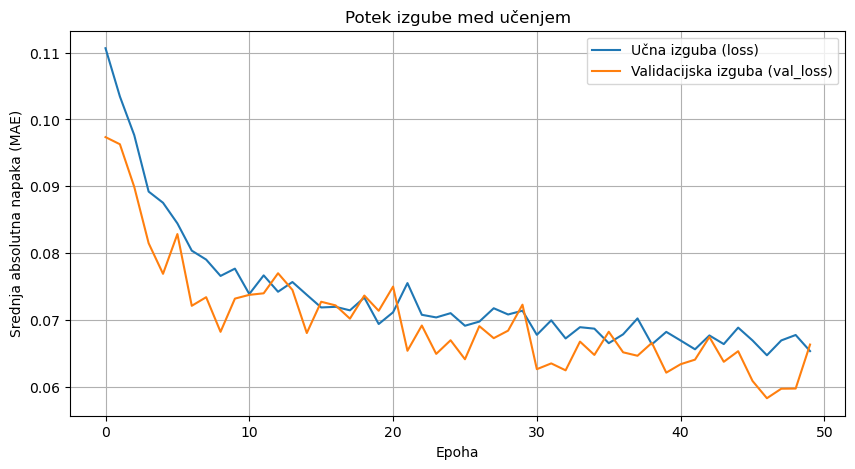

Generiram primer za vrednotenje...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


/tmp/ipykernel_5288/2093364907.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


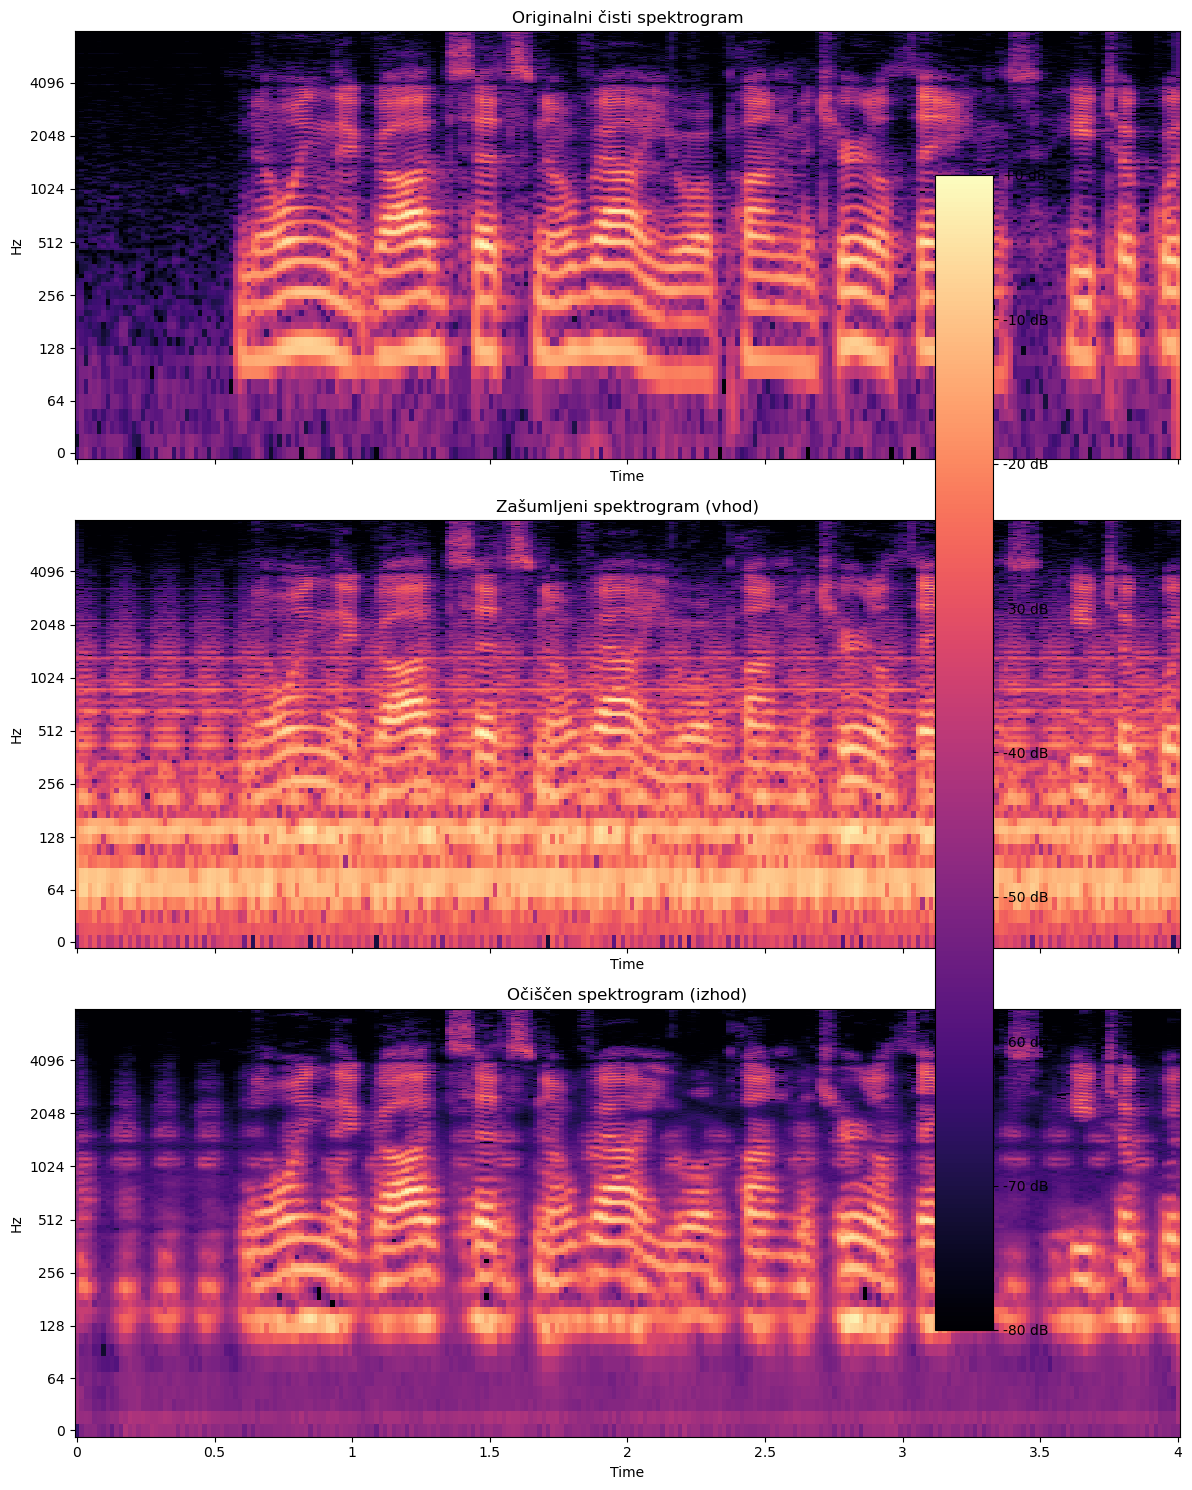


Končano! Rezultati so shranjeni v mapi 'results'.


In [4]:
import os
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# --- Globalne nastavitve ---
CLEAN_SPEECH_PATH = os.path.join('datasets', 'librispeech', 'LibriSpeech', 'dev-clean')
NOISE_PATH = os.path.join('datasets', 'urbansound8k', 'audio')
RESULTS_PATH = 'results'

SAMPLE_RATE = 16000
DURATION = 4
N_FFT = 1024
HOP_LENGTH = 256
N_SAMPLES = SAMPLE_RATE * DURATION

BATCH_SIZE = 8
EPOCHS = 50

# --- 2. Gradnja modela U-Net (nespremenjena) ---
def build_unet_model(input_shape):
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)
    up4 = UpSampling2D(size=(2, 2))(conv3)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(32, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(32, 3, activation='relu', padding='same')(conv4)
    up5 = UpSampling2D(size=(2, 2))(conv4)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(16, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(16, 3, activation='relu', padding='same')(conv5)
    outputs = Conv2D(1, 1, activation='relu')(conv5)
    model = Model(inputs, outputs)
    return model

# --- 3. Funkcije za vrednotenje (s prilagoditvijo za padding) ---
def plot_loss_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Učna izguba (loss)')
    plt.plot(history.history['val_loss'], label='Validacijska izguba (val_loss)')
    plt.title('Potek izgube med učenjem')
    plt.xlabel('Epoha')
    plt.ylabel('Srednja absolutna napaka (MAE)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(RESULTS_PATH, 'loss_history.png'))
    plt.show()


# --- Glavni program ---
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)


model = build_unet_model(input_shape)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_absolute_error')
model.summary()

steps_per_epoch = len(train_files) // BATCH_SIZE
validation_steps = len(val_files) // BATCH_SIZE

print("\n--- Začetek učenja ---")
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps
)
print("--- Konec učenja ---")

model.save(os.path.join(RESULTS_PATH, 'speech_enhancement_unet.h5'))

print("\n--- Začetek vrednotenja ---")
plot_loss_history(history)

Generiram primer za vrednotenje...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


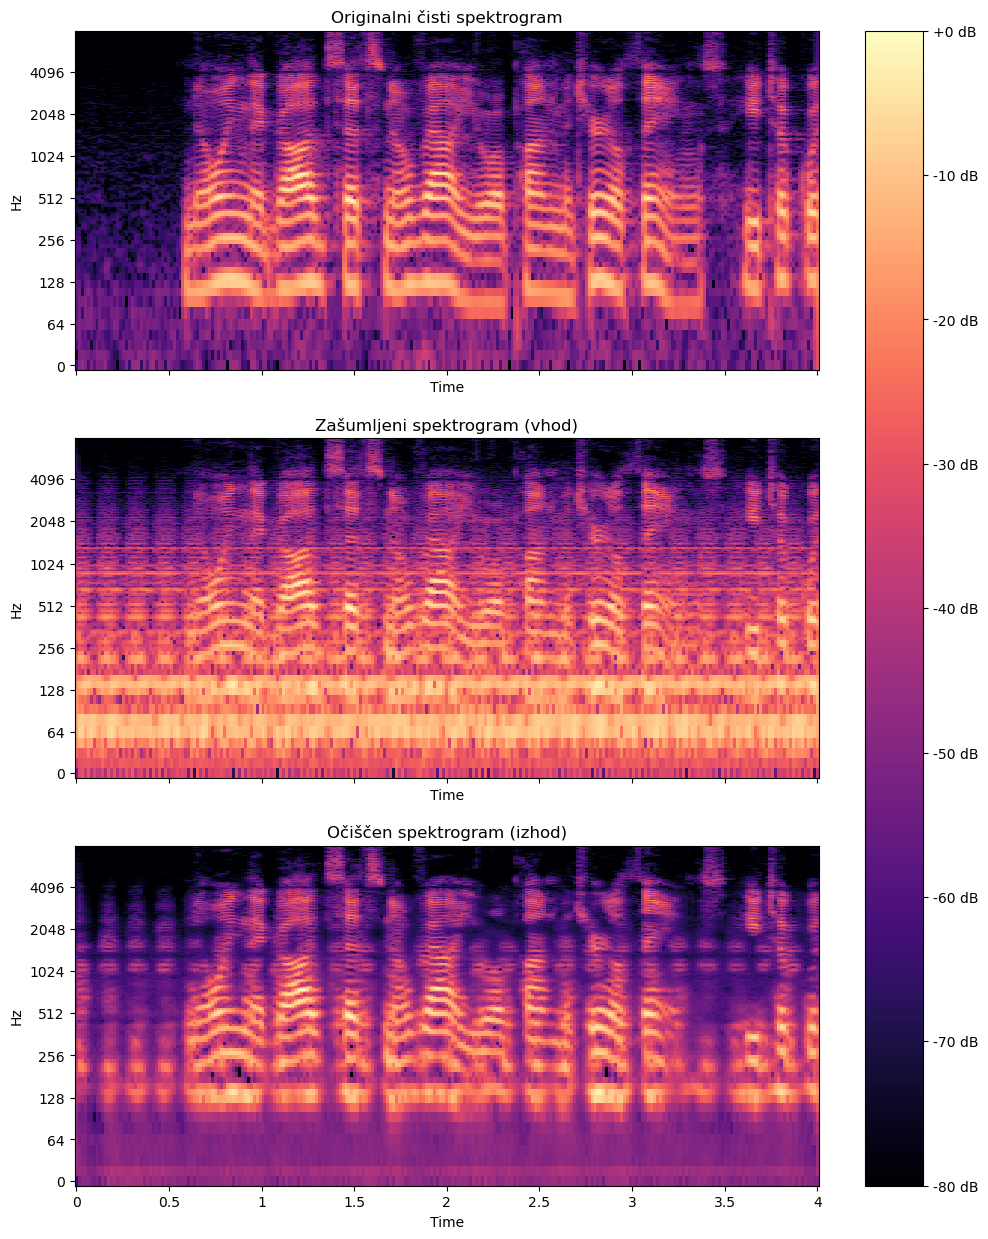


Končano! Rezultati so shranjeni v mapi 'results'.


In [8]:
print("Generiram primer za vrednotenje...")
evaluate_and_save_example(model, val_files[0], noise_files[0], file_id='01', input_shape=input_shape)

print(f"\nKončano! Rezultati so shranjeni v mapi '{RESULTS_PATH}'.")